In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import random

import gc
import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = "sepsis_patients.csv"
sepsis_patients = pd.read_csv(file_path)

In [3]:
sepsis_patients.head()

,hadm_id,sirs_criteria_count,first_sirs_5h_time,sepsis
0,103667.0,3,2123-04-11 13:00:00,1
1,106220.0,2,2181-10-17 15:00:00,1
2,107741.0,3,2136-10-04 18:00:00,1
3,108841.0,5,2186-01-18 07:00:00,1
4,111687.0,2,2123-06-23 05:00:00,1


In [4]:
file_path = "no_sepsis_patients.csv"
no_sepsis_patients = pd.read_csv(file_path)

In [5]:
no_sepsis_patients.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,age,row_id_y,...,row_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,8,9,M,2108-01-26,2149-11-14 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,1,41,8,...,9,220597,carevue,MICU,MICU,15,15,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231
1,27,31,M,2036-05-17,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1,136,30,...,31,254478,carevue,MICU,MICU,15,15,2108-08-22 23:28:42,2108-08-30 21:59:20,7.9379
2,52,59,F,2110-10-12,2198-09-06 00:00:00,2198-09-06 00:00:00,2198-09-06 00:00:00,1,73,58,...,60,224440,carevue,MICU,MICU,50,50,2197-11-14 17:07:48,2197-11-16 21:58:12,2.2017
3,56,63,M,2080-07-07,NaN,NaN,NaN,0,37,63,...,65,244541,carevue,MICU,MICU,52,52,2169-01-07 01:52:56,2169-01-07 14:25:27,0.5226
4,70,78,M,2128-07-01,2180-02-02 00:00:00,NaN,2180-02-02 00:00:00,1,42,79,...,82,233150,carevue,MICU,MICU,12,12,2177-02-14 04:10:26,2177-02-15 15:54:43,1.4891


# ===============================================================

### Extração dos sinais vitais

In [8]:
variable_codes = {
    "systolic_pressure": [220050, 51, 220179, 224167, 225309, 227243, 3315, 3321, 6721],
    "diastolic_pressure": [220051, 8368, 8364, 8440, 8503, 8506, 8555, 220180, 224643, 225310, 227242],
    "heart_rate": [211, 220045, 3494, 188, 81, 549, 603, 2702, 8489, 8372, 8386, 8456, 8473],
    "temperature": [676, 223762, 677, 678, 679, 223761, 8537],
    "respiration_rate": [614, 615, 618, 619, 3603, 1635, 1884, 220210, 224688, 224689, 224690],
    "wbc": [861, 1127, 1542, 220546],
    "ph": [780, 223830, 228243],
    "oxygen_saturation": [646, 220277, 220277, 226861],
}

lab_variable_codes = {
    "wbc": [51300, 51301, 51516],
    "ph": [50820],
    "oxygen_saturation": [50817]
}

all_codes = {code: measurement for measurement, codes in variable_codes.items() for code in codes}

lab_codes = {code: measurement for measurement, codes in lab_variable_codes.items() for code in codes}

### Montar um subset de chartevents que contém apenas dados dos pacientes selecionados e das medidas indicadas

In [10]:
chartevents_chunks = pd.read_csv(
    "mimic-iii-clinical-database-carevue-subset-1.4/CHARTEVENTS.csv.gz",
    chunksize=500000,
    engine="python",
    on_bad_lines="skip"
)

filtered_chartevents = pd.DataFrame()

for i, chunk in enumerate(chartevents_chunks):
    chunk = chunk[['hadm_id', 'itemid', 'charttime', 'valuenum']]
    chunk = chunk[
        (chunk["hadm_id"].isin(sepsis_patients["hadm_id"])) |
        (chunk["hadm_id"].isin(no_sepsis_patients["hadm_id"]))
    ]
    chunk = chunk[chunk["itemid"].isin(all_codes.keys())]

    chunk["measurement"] = chunk["itemid"].map(all_codes)

    chunk.loc[chunk["measurement"] == "temperature", "valuenum"] = chunk.apply(
        lambda row: (row["valuenum"] - 32) * 5 / 9 if row["itemid"] in [678, 679, 223761] else row["valuenum"],
        axis=1
    )

    filtered_chartevents = pd.concat([filtered_chartevents, chunk], ignore_index=True)
    print(f"Chunk {i + 1} processado e filtrado.")
    
# Lab values
labevents_chunks = pd.read_csv(
    "mimic-iii-clinical-database-carevue-subset-1.4/LABEVENTS.csv.gz",
    chunksize=800000,
    engine="python",
    on_bad_lines="skip"
)

for i, chunk in enumerate(labevents_chunks):
    chunk = chunk[['hadm_id', 'itemid', 'charttime', 'valuenum']]
    chunk = chunk[
        (chunk["hadm_id"].isin(sepsis_patients["hadm_id"])) |
        (chunk["hadm_id"].isin(no_sepsis_patients["hadm_id"]))
    ]
    chunk = chunk[chunk["itemid"].isin(lab_codes.keys())]

    chunk["measurement"] = chunk["itemid"].map(lab_codes)
    
    filtered_chartevents = pd.concat([filtered_chartevents, chunk], ignore_index=True)
    print(f"Chunk {i + 1} processado e filtrado.")
    
filtered_chartevents.to_csv(f"filtered_chartevents.csv", index=False)

# ===============================================================

### Usando o dataset filtrado

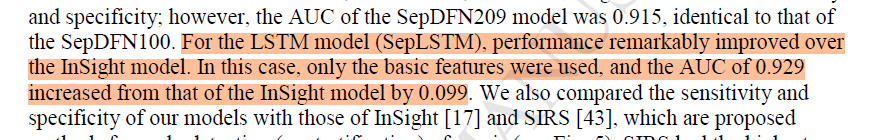

    O trabalho de Kam, 2017 testa diferentes combinações de features sendo as 100 features criadas por eles, as 109 usadas pelo trabalho original, e as 209 combinadas. A melhor solução são as 100 features criadas pelo trabalho de Kam, 2017.

In [15]:
chartevents = pd.read_csv(f"filtered_chartevents.csv")

In [16]:
def aggregate_measurements(data):
    aggregated = {
        'Systolic pressure Average': None,
        'Systolic pressure Max': None,
        'Pulse pressure Min': None,
        'Pulse pressure Average': None,
        'Pulse pressure Max': None,
        'Heart rate Min': None,
        'Heart rate Average': None,
        'Heart rate Max': None,
        'Temperature Average': None,
        'Temperature Max': None,
        'Respiration rate Min': None,
        'Respiration rate Average': None,
        'Respiration rate Max': None,
        'WBC count Min': None,
        'WBC count Average': None,
        'WBC count Max': None,
        'pH Min': None,
        'pH Average': None,
        'Blood oxygen saturation Average': None,
        'Blood oxygen saturation Max': None
    }

    if 'systolic_pressure' in data['measurement'].values and 'diastolic_pressure' in data['measurement'].values:
        systolic = data[data['measurement'] == 'systolic_pressure']['valuenum'].values
        diastolic = data[data['measurement'] == 'diastolic_pressure']['valuenum'].values
        
        pulse_pressure = []
        if len(systolic) == len(diastolic):
            pulse_pressure = systolic - diastolic
        elif len(systolic) > len(diastolic):
            pulse_pressure = systolic[:len(diastolic)] - diastolic
        elif len(diastolic) > len(systolic):
            pulse_pressure = systolic - diastolic[:len(systolic)]
        
        aggregated['Systolic pressure Average'] = systolic.mean()
        aggregated['Systolic pressure Max'] = systolic.max()
        aggregated['Pulse pressure Min'] = pulse_pressure.min()
        aggregated['Pulse pressure Average'] = pulse_pressure.mean()
        aggregated['Pulse pressure Max'] = pulse_pressure.max()

    if 'heart_rate' in data['measurement'].values:
        heart_rate = data[data['measurement'] == 'heart_rate']['valuenum']
        aggregated['Heart rate Min'] = heart_rate.min()
        aggregated['Heart rate Average'] = heart_rate.mean()
        aggregated['Heart rate Max'] = heart_rate.max()

    if 'temperature' in data['measurement'].values:
        temperature = data[data['measurement'] == 'temperature']['valuenum']
        aggregated['Temperature Average'] = temperature.mean()
        aggregated['Temperature Max'] = temperature.max()

    if 'respiration_rate' in data['measurement'].values:
        respiration_rate = data[data['measurement'] == 'respiration_rate']['valuenum']
        aggregated['Respiration rate Min'] = respiration_rate.min()
        aggregated['Respiration rate Average'] = respiration_rate.mean()
        aggregated['Respiration rate Max'] = respiration_rate.max()

    if 'wbc' in data['measurement'].values:
        wbc = data[data['measurement'] == 'wbc']['valuenum']
        aggregated['WBC count Min'] = wbc.min()
        aggregated['WBC count Average'] = wbc.mean()
        aggregated['WBC count Max'] = wbc.max()

    if 'ph' in data['measurement'].values:
        ph = data[data['measurement'] == 'ph']['valuenum']
        aggregated['pH Min'] = ph.min()
        aggregated['pH Average'] = ph.mean()

    if 'oxygen_saturation' in data['measurement'].values:
        oxygen_saturation = data[data['measurement'] == 'oxygen_saturation']['valuenum']
        aggregated['Blood oxygen saturation Average'] = oxygen_saturation.mean()
        aggregated['Blood oxygen saturation Max'] = oxygen_saturation.max()

    return aggregated

In [17]:
def transform_to_hourly_dataframe(hourly_aggregated, sepsis):
    expected_hours = [1, 2, 3, 4, 5]  # Horas esperadas
    record = {'sepsis': sepsis}

    if isinstance(hourly_aggregated, pd.DataFrame):
        if hourly_aggregated.empty:
            return pd.DataFrame([record])
        hourly_aggregated = hourly_aggregated.to_dict(orient='index')

    if isinstance(hourly_aggregated, pd.Series):
        hourly_aggregated = {k: v for k, v in hourly_aggregated.items()}
    elif isinstance(hourly_aggregated, np.ndarray):
        hourly_aggregated = {i: row for i, row in enumerate(hourly_aggregated)}

    if not hourly_aggregated:
        return pd.DataFrame([record])

    actual_hours = sorted(hourly_aggregated.keys())  # Garante ordem crescente
    hour_mapping = {actual_hours[i]: actual_hours[i] + 1 for i in range(len(actual_hours))}

    for expected_hour in expected_hours:
        if expected_hour in hour_mapping.values():
            actual_hour = [h for h, idx in hour_mapping.items() if idx == expected_hour][0]
            for metric, value in hourly_aggregated[actual_hour].items():
                record[f"{metric} hour {expected_hour}"] = value
        else:
            # Se a hora não está presente, preenche com None
            sample_metrics = next(iter(hourly_aggregated.values()), {})
            if isinstance(sample_metrics, np.ndarray):
                sample_metrics = {f"feature_{i}": v for i, v in enumerate(sample_metrics)}
            for metric in sample_metrics.keys():
                record[f"{metric} hour {expected_hour}"] = None

    return pd.DataFrame([record])

In [18]:
hours_before_sepsis = [0, 1, 2, 3]

feature_selection_offset_0 = []
feature_selection_offset_1 = []
feature_selection_offset_2 = []
feature_selection_offset_3 = []

feature_selection_no_sepsis = []

sepsis_patients_hadm_ids = sepsis_patients['hadm_id'].unique()

no_sepsis_patients_hadm_ids = no_sepsis_patients['hadm_id'].unique()

for patient in chartevents['hadm_id'].unique():
    if patient in sepsis_patients_hadm_ids:
        patient_data = sepsis_patients[sepsis_patients['hadm_id'] == patient]
        sepsis_timestamp = pd.to_datetime(patient_data['first_sirs_5h_time'].iloc[0])
        
        chartevents['charttime'] = pd.to_datetime(chartevents['charttime'])
        
        for offset in hours_before_sepsis:
            upper_limit = sepsis_timestamp - timedelta(hours=offset)
            lower_limit = upper_limit - timedelta(hours=5)

            patient_chartevents = chartevents[
                (chartevents['hadm_id'] == patient) &
                (chartevents['charttime'] > lower_limit) &
                (chartevents['charttime'] <= upper_limit)
            ]
            
            patient_chartevents['time_diff'] = (patient_chartevents['charttime'] - lower_limit).dt.total_seconds() / 3600
            patient_chartevents = patient_chartevents[(patient_chartevents['time_diff'] >= 0) & (patient_chartevents['time_diff'] < 5)]
            patient_chartevents['hour'] = patient_chartevents['time_diff'].astype(int)
            hourly_aggregated = patient_chartevents.groupby('hour').apply(aggregate_measurements)
            
            hourly_aggregated = transform_to_hourly_dataframe(hourly_aggregated, 1)
            
            if offset == 0:
                feature_selection_offset_0.append(hourly_aggregated)
            elif offset == 1:
                feature_selection_offset_1.append(hourly_aggregated)
            elif offset == 2:
                feature_selection_offset_2.append(hourly_aggregated)
            elif offset == 3:
                feature_selection_offset_3.append(hourly_aggregated)
                
    elif patient in no_sepsis_patients_hadm_ids:
        patient_data = no_sepsis_patients[no_sepsis_patients['hadm_id'] == patient]
        intime = pd.to_datetime(patient_data['intime'].iloc[0])
        outtime = pd.to_datetime(patient_data['outtime'].iloc[0])

        # Garantir que a internação seja maior que 8 horas (5 horas de dados + 3 horas de exclusão)
        if (outtime - intime).total_seconds() / 3600 > 8:
            valid_start_time = intime
            valid_end_time = outtime - timedelta(hours=3)

            chartevents['charttime'] = pd.to_datetime(chartevents['charttime'])
        
            total_hours = int((valid_end_time - valid_start_time).total_seconds() / 3600)
            random_hour_offset = random.randint(0, total_hours - 5)
            random_start_time = valid_start_time + timedelta(hours=random_hour_offset)
            random_start_time = random_start_time.replace(minute=0, second=0, microsecond=0)
            random_end_time = random_start_time + timedelta(hours=5)

            patient_chartevents = chartevents[
                (chartevents['hadm_id'] == patient) &
                (chartevents['charttime'] > random_start_time) &
                (chartevents['charttime'] <= random_end_time)
            ]
            patient_chartevents['time_diff'] = (patient_chartevents['charttime'] - random_start_time).dt.total_seconds() / 3600
            patient_chartevents = patient_chartevents[(patient_chartevents['time_diff'] >= 0) & (patient_chartevents['time_diff'] < 5)]
            patient_chartevents['hour'] = patient_chartevents['time_diff'].astype(int)

            hourly_aggregated = patient_chartevents.groupby('hour').apply(aggregate_measurements)
            hourly_aggregated = transform_to_hourly_dataframe(hourly_aggregated, 0)

            feature_selection_no_sepsis.append(hourly_aggregated)
                
feature_selection_offset_0 = pd.concat(feature_selection_offset_0, ignore_index=True)
feature_selection_offset_1 = pd.concat(feature_selection_offset_1, ignore_index=True)
feature_selection_offset_2 = pd.concat(feature_selection_offset_2, ignore_index=True)
feature_selection_offset_3 = pd.concat(feature_selection_offset_3, ignore_index=True)
feature_selection_no_sepsis = pd.concat(feature_selection_no_sepsis, ignore_index=True)

columns_to_check = feature_selection_no_sepsis.columns.difference(['sepsis'])

# Remover pacientes que tenham todas as features nulas
feature_selection_offset_0 = feature_selection_offset_0[
    ~(feature_selection_offset_0[columns_to_check].isnull().all(axis=1))
]

feature_selection_offset_1 = feature_selection_offset_1[
    ~(feature_selection_offset_1[columns_to_check].isnull().all(axis=1))
]

feature_selection_offset_2 = feature_selection_offset_2[
    ~(feature_selection_offset_2[columns_to_check].isnull().all(axis=1))
]

feature_selection_offset_3 = feature_selection_offset_3[
    ~(feature_selection_offset_3[columns_to_check].isnull().all(axis=1))
]

feature_selection_no_sepsis = feature_selection_no_sepsis[
    ~(feature_selection_no_sepsis[columns_to_check].isnull().all(axis=1))
]

feature_selection_offset_0.to_csv(f"feature_selection_offset_0.csv", index=False)
feature_selection_offset_1.to_csv(f"feature_selection_offset_1.csv", index=False)
feature_selection_offset_2.to_csv(f"feature_selection_offset_2.csv", index=False)
feature_selection_offset_3.to_csv(f"feature_selection_offset_3.csv", index=False)
feature_selection_no_sepsis.to_csv(f"feature_selection_no_sepsis.csv", index=False)

KeyboardInterrupt: 